## Minimizer template

This notebook contains the basic syntax required to run a minimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.emulator import p1d_archive_Nyx
from lace_manager.likelihood import full_theory
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
use_nyx=False
if use_nyx:
    nyx_dir='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/'
    nyx_fname=nyx_dir+'/large_nyx_models.hdf5'
    nyx_fid_igm=nyx_dir+'/fiducial_nyx_igm_evolution.txt'
else:
    nyx_fname=None
    nyx_fid_igm=None

In [3]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [4]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"),
                                nyx_fname=nyx_fname)

### Emulator and training set

Create a set of training data to train an emulator

In [5]:
# Setup archive of P1D entries
if use_nyx:
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=nyx_fname)
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
else:
    archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']

In [6]:
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.36 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
free_param_names=["As","ns","ln_tau_0"]
#free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]
#free_param_names=["ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]
prior=0.5

In [10]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,
                            include_CMB=False,
                            #fid_igm_fname=nyx_fid_igm,
                            cosmo_fid_label='truth',
                            emu_cov_factor=0.0)

use true cosmo
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


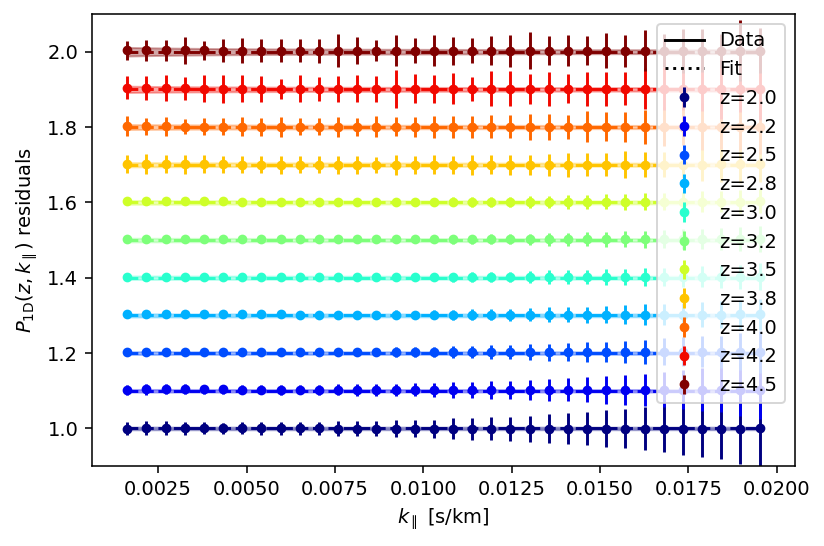

In [11]:
like.plot_p1d(residuals=True)

# Try iminuit minimizer

In [12]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [13]:
minimizer.minimize(compute_hesse=True)

will run migrad
will compute Hessian matrix


best-fit values = [0.46221929 0.47800169 0.50480955]


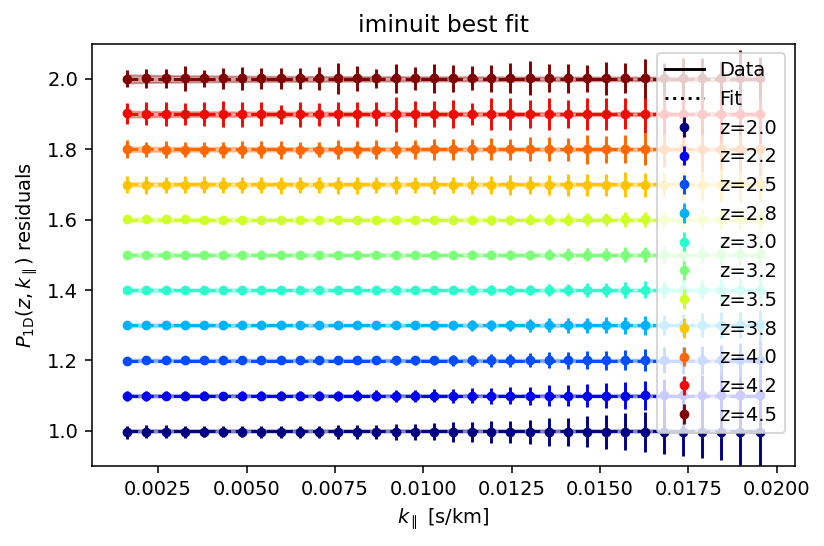

<Figure size 840x560 with 0 Axes>

In [14]:
plt.figure()
minimizer.plot_best_fit()
plt.savefig('best_fit_Nyx.pdf')

compute true values for As ns


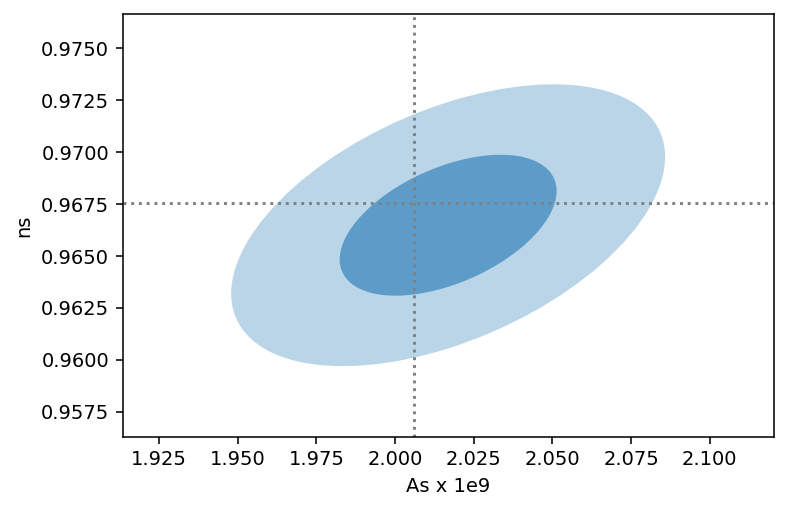

In [15]:
minimizer.plot_ellipses('As','ns')
plt.savefig('contours_Nyx.pdf')

### Access the actual minimizer object from iminuit

In [ ]:
minimizer.minimizer.migrad()

In [ ]:
minimizer.minimizer.draw_mncontour("x0", "x1")

In [ ]:
minimizer.minimizer.draw_mnprofile("x0")